****Отток клиентов****

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

**Цель исследования** - спрогнозировать уйдёт клиент из банка в ближайшее время или нет.

Построить модель со значением *F1*-меры > 0.59

**Признаки**: <br><br>
`RowNumber` — индекс строки в данных; <br>
`CustomerId` — уникальный идентификатор клиента; <br>
`Surname` — фамилия;<br>
`CreditScore` — кредитный рейтинг;<br>
`Geography` — страна проживания;<br>
`Gender` — пол;<br>
`Age` — возраст;<br>
`Tenure` — сколько лет человек является клиентом банка;<br>
`Balance` — баланс на счёте;<br>
`NumOfProducts` — количество продуктов банка, используемых клиентом;<br>
`HasCrCard` — наличие кредитной карты;<br>
`IsActiveMember` — активность клиента;<br>
`EstimatedSalary` — предполагаемая зарплата.<br><br>
**Целевой признак**:<br><br>
`Exited` — факт ухода клиента.

In [1]:
import pandas as pd                     # импорт библиотек
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, precision_recall_curve 
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import sweetviz as sv
import seaborn as sns
from random import randint
import random

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv') # чтение файла с данными и сохранение в df
except:
    df = pd.read_csv('C:\\Users\\User\\Downloads\\Churn.csv')

## Подготовка данных

In [3]:
report = sv.analyze([df, "DF"])

                                             |                                             | [  0%]   00:00 ->…

In [4]:
report.show_html('common analysis.html')

Report common analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [5]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5.0,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10.0,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7.0,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3.0,75075.31,2,1,0,92888.52,1


In [6]:
df.info() # проверка на пропуски

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


Пропуски в столбце Tenure.<br>
Gender, Geography, Surname - тип object.

In [7]:
df['Tenure'].value_counts() # список значений до замены для проверки

1.0     952
2.0     950
8.0     933
3.0     928
5.0     927
7.0     925
4.0     885
9.0     882
6.0     881
10.0    446
0.0     382
Name: Tenure, dtype: int64

In [8]:
df.loc[df['Tenure'].isna(), 'Tenure'] = df.loc[df['Tenure'].isna(), 'Tenure'].apply(lambda x: random.randint(0,10)) 
# замена отсутствующих значений случайными числами 

In [9]:
df['Tenure'].value_counts() # список значений после замены

1.0     1050
2.0     1034
8.0     1025
5.0     1002
7.0      995
3.0      994
9.0      976
4.0      970
6.0      952
10.0     536
0.0      466
Name: Tenure, dtype: int64

In [10]:
df.drop(['RowNumber','CustomerId','Surname'], axis = 1, inplace = True) # удаление столбцов не нужных для исследования

In [11]:
df = pd.get_dummies(df,columns=['Gender'], drop_first=True) # преобразование категориальных признаков в численные

In [12]:
df = pd.get_dummies(df, columns = ['Geography']) # преобразование категориальных признаков в численные

In [13]:
print(df.duplicated().sum()) # поиск дубликатов

0


In [14]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['Exited'])# разделение выборок 
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=12345)#на обучающую,валидационную и тестовую

In [15]:
features_train = df_train.drop(['Exited'], axis=1)     # признаки для обучающей выборки                        
target_train = df_train['Exited']                      # целевой признак для обучающей выборки   

features_valid = df_valid.drop(['Exited'], axis=1)     # признаки для валидационной выборки 
target_valid = df_valid['Exited']                      # целевой признак для валидационной выборки 

features_test = df_test.drop(['Exited'], axis=1)       # признаки для тестовой выборки 
target_test = df_test['Exited']                        # целевой признак для тестовой выборки 

print(features_train.shape)    # размер выборок
print(target_train.shape)
print(features_valid.shape)
print(target_valid.shape)
print(features_test.shape)
print(target_test.shape)

(6000, 12)
(6000,)
(2000, 12)
(2000,)
(2000, 12)
(2000,)


In [16]:
print(f"Количество строк в target_train по классам: {np.bincount(target_train)}") # проверим равномерно ли разбиты 
print(f"Количество строк в target_valid по классам: {np.bincount(target_valid)}")  # данные  по классам
print(f"Количество строк в target_test по классам: {np.bincount(target_test)}")

Количество строк в target_train по классам: [4778 1222]
Количество строк в target_valid по классам: [1609  391]
Количество строк в target_test по классам: [1576  424]


In [17]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Gender_Male',
       'Geography_France', 'Geography_Germany', 'Geography_Spain']
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric]= scaler.transform(features_valid[numeric])
features_test[numeric]= scaler.transform(features_test[numeric]) # проведем масштабирование признаков

Вывод по подготовке:
 - удалены столбцы 'RowNumber','CustomerId','Surname' не нужные для исследования.
 - категориальные признаки преобразованны в численные.
 - данные разделены на выборки train, test и valid с параметром stratify=df['Exited'] для равномерного распределения признаков в выборках.
 - признаки приведены к одному масштабу.


## Исследование задачи

Проверим баланс классов.

0    0.7963
1    0.2037
Name: Exited, dtype: float64


<AxesSubplot:>

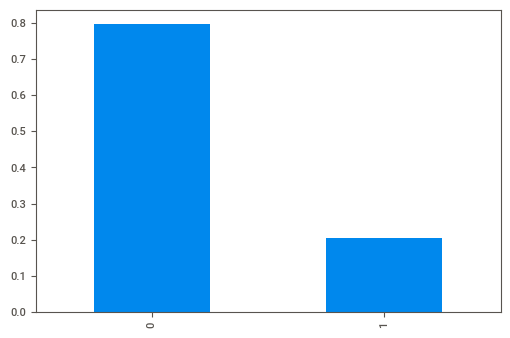

In [18]:
class_frequency = df['Exited'].value_counts(normalize=True)
print(class_frequency)
class_frequency.plot(kind='bar')

Наблюдается дисбаланс классов. Класса 1 намного меньше класса 0. 

Обучим решающее дерево без учета дисбаланса.

In [19]:
model_1 = DecisionTreeClassifier(random_state=12345)

In [20]:
parametrs = { 'max_depth': range (1,20, 1),  # параметры для поиска лучшей модели
              'min_samples_leaf': range (1,40),
              'min_samples_split': range (2,20,2)}

In [21]:
grid_tree = GridSearchCV(model_1, parametrs, cv=5, scoring='f1')   
grid_tree.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             param_grid={'max_depth': range(1, 20),
                         'min_samples_leaf': range(1, 40),
                         'min_samples_split': range(2, 20, 2)},
             scoring='f1')

In [22]:
grid_tree.best_params_   # выводим результат с лучшими параметрами

{'max_depth': 12, 'min_samples_leaf': 17, 'min_samples_split': 2}

In [23]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=12, min_samples_leaf=17, min_samples_split=2)
model_dt.fit(features_train, target_train) # обучение  
predictions_valid = model_dt.predict(features_valid) # предсказания на валидационной выборке
print("Recall:",recall_score(target_valid, predictions_valid))
print("Precision:",precision_score(target_valid, predictions_valid))
print("F1:",f1_score(target_valid, predictions_valid))
probabilities = model_dt.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one))

Recall: 0.45268542199488493
Precision: 0.6389891696750902
F1: 0.5299401197604792
auc_roc: 0.8132944641633777


Обучим случайный лес без учета дисбаланса.

In [24]:
model_2 = RandomForestClassifier(random_state=12345)

In [25]:
parametrs = { 'n_estimators': range (10, 31, 10),   # параметры для поиска лучшей модели
              'max_depth': range (1, 10, 2),
              'min_samples_leaf': range (1,10),
              'min_samples_split': range (2,10,2),
              'criterion': ['gini', 'entropy']}

In [26]:
grid = GridSearchCV(model_2, parametrs, cv=5, scoring='f1')   
grid.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 10, 2),
                         'min_samples_leaf': range(1, 10),
                         'min_samples_split': range(2, 10, 2),
                         'n_estimators': range(10, 31, 10)},
             scoring='f1')

In [27]:
grid.best_params_   # выводим результат с лучшими параметрами

{'criterion': 'gini',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 30}

In [28]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=20, min_samples_leaf=1,
                    min_samples_split=4) 
model_rf.fit(features_train, target_train) # обучение  
predictions_valid = model_rf.predict(features_valid) # предсказания на валидационной выборке
print("Recall:",recall_score(target_valid, predictions_valid))
print("Precision:",precision_score(target_valid, predictions_valid))
print("F1:",f1_score(target_valid, predictions_valid))
probabilities = model_rf.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one))

Recall: 0.42710997442455245
Precision: 0.7522522522522522
F1: 0.5448613376835236
auc_roc: 0.8568728650700425


Обучение логистической регрессии без учета дисбаланса.

In [29]:
model_2 = LogisticRegression(random_state=12345) 

In [30]:
parametrs = { 'max_iter': [100, 1001, 1000],   # параметры для поиска лучшей модели
              'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }

In [31]:
grid = GridSearchCV(model_2, parametrs, scoring='f1')   
grid.fit(features_train, target_train)

GridSearchCV(estimator=LogisticRegression(random_state=12345),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'max_iter': [100, 1001, 1000]},
             scoring='f1')

In [32]:
grid.best_params_

{'C': 1, 'max_iter': 100}

In [33]:
model_2 = LogisticRegression(random_state=12345, max_iter=100, C=1)  
model_2.fit(features_train, target_train) #  обучение модели
LogisticRegression_predict = model_2.predict(features_valid) #предсказания на валидационной выборке
print(model_2.score(features_valid, target_valid))
print("Recall:",recall_score(target_valid, predictions_valid))
print("Precision:",precision_score(target_valid, predictions_valid))
print("F1:",f1_score(target_valid, predictions_valid))
probabilities = model_2.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one))

0.815
Recall: 0.42710997442455245
Precision: 0.7522522522522522
F1: 0.5448613376835236
auc_roc: 0.7704265806627998


Самое высокое значение F1 без учета дисбаланса у модели случайный лес 0.56 и логистическая регрессия.

| Имя модели    | Значение F1        | ROC-AUC  |
|:------------- |:---------------:| :---------------:|
| Случайный лес      | 0.56 | 0.85 | 
| Решающее дерево        | 0.52        | 0.80        |
| Логистическая регрессия | 0.56        | 0.76|

## Борьба с дисбалансом

### Взвешивание классов

**Для борьбы с дисбалансом применим аргумент class_weight**

In [34]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf=8, min_samples_split=2,
                                 class_weight={1:2, 0:1})
model_dt.fit(features_train, target_train)  
predictions_valid = model_dt.predict(features_valid) 
print("Recall:",recall_score(target_valid, predictions_valid))
print("Precision:",precision_score(target_valid, predictions_valid))
print("F1:",f1_score(target_valid, predictions_valid))
probabilities = model_dt.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one))

Recall: 0.5191815856777494
Precision: 0.656957928802589
F1: 0.58
auc_roc: 0.8186988471179538


In [35]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=40, min_samples_leaf=1,
                    min_samples_split=8, class_weight='balanced') 
model_rf.fit(features_train, target_train)  
predictions_valid = model_rf.predict(features_valid) 
print("Recall:",recall_score(target_valid, predictions_valid))
print("Precision:",precision_score(target_valid, predictions_valid))
print("F1:",f1_score(target_valid, predictions_valid))
probabilities = model_rf.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one))

Recall: 0.6470588235294118
Precision: 0.5584988962472406
F1: 0.5995260663507109
auc_roc: 0.8541309354827941


In [36]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid) 
print("Recall:",recall_score(target_valid, predictions_valid))
print("Precision:",precision_score(target_valid, predictions_valid))
print("F1:",f1_score(target_valid, predictions_valid))
probabilities = model.predict_proba(features_valid)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one))

Recall: 0.710997442455243
Precision: 0.3813443072702332
F1: 0.4964285714285715
auc_roc: 0.7755051111157031


У логистической регрессии снизилась точность и следовательно F1 стала хуже. У остальных моделей метрики качества повысились.

### Увеличение выборки

**Применим увеличение количества объектов редкого класса**

In [37]:
def upsample(features, target, repeat):

    features_zeros = features_train[target_train == 0]
    features_ones = features_train[target_train == 1]
    target_zeros = target_train[target_train == 0]
    target_ones = target_train[target_train == 1]
    repeat = 4
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled 
features_upsampled, target_upsampled = upsample(features_train, target_train, 4)

print(features_upsampled.shape)
print(target_upsampled.shape)

(9666, 12)
(9666,)


In [38]:
target_upsampled.value_counts()

1    4888
0    4778
Name: Exited, dtype: int64

In [39]:
target_train.value_counts()

0    4778
1    1222
Name: Exited, dtype: int64

In [40]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=40, min_samples_leaf=1,
                    min_samples_split=8) 
model_rf.fit(features_upsampled, target_upsampled)
predicted_valid = model_rf.predict(features_valid)
print("Recall:",recall_score(target_valid, predicted_valid))
print("Precision:",precision_score(target_valid, predicted_valid))
probabilities_valid = model_rf.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Recall: 0.6956521739130435
Precision: 0.5230769230769231
auc_roc: 0.8540117211529138
F1: 0.597145993413831


In [41]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100, C=0.1)
model.fit(features_upsampled, target_upsampled)
model.predict_proba(features_valid)[:,1]
predicted_valid = model.predict(features_valid)
print("Recall:",recall_score(target_valid, predicted_valid))
print("Precision:",precision_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Recall: 0.7212276214833759
Precision: 0.3780160857908847
auc_roc: 0.7755829978112249
F1: 0.496042216358839


In [42]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf=8, min_samples_split=2)
model_dt.fit(features_upsampled, target_upsampled)
predicted_valid = model_dt.predict(features_valid)
print("Recall:",recall_score(target_valid, predicted_valid))
print("Precision:",precision_score(target_valid, predicted_valid))
probabilities_valid = model_dt.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Recall: 0.7391304347826086
Precision: 0.41944847605224966
auc_roc: 0.7997421791425787
F1: 0.5351851851851852


При увеличении выборки только у модели Случайный лес F1 больше, чем на не сбалансированной.

### Уменьшение выборки

**Применим уменьшение количества объектов большего класса**

In [43]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

features_downsampled, target_downsampled = downsample(features_train, target_train, 0.27)

print(features_downsampled.shape)
print(target_downsampled.shape)

(2512, 12)
(2512,)


In [44]:
target_downsampled.value_counts()

0    1290
1    1222
Name: Exited, dtype: int64

In [45]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100, C=0.1)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("Recall:",recall_score(target_valid, predicted_valid))
print("Precision:",precision_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one_valid)) 
print("F1:", f1_score(target_valid, predicted_valid))

Recall: 0.6956521739130435
Precision: 0.38636363636363635
auc_roc: 0.7728458367971719
F1: 0.4968036529680366


In [46]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf=8, min_samples_split=2)
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("Recall:",recall_score(target_valid, predicted_valid))
print("Precision:",precision_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Recall: 0.8260869565217391
Precision: 0.38682634730538923
auc_roc: 0.8335537473832455
F1: 0.5269168026101142


In [47]:
model = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=40, min_samples_leaf=1,
                    min_samples_split=8) 
model.fit(features_downsampled, target_downsampled)
predicted_valid = model.predict(features_valid)
print("Recall:",recall_score(target_valid, predicted_valid))
print("Precision:",precision_score(target_valid, predicted_valid))
probabilities_valid = model.predict_proba(features_valid)
probabilities_one_valid = probabilities_valid[:, 1]
print("auc_roc:", roc_auc_score(target_valid, probabilities_one_valid))
print("F1:", f1_score(target_valid, predicted_valid))

Recall: 0.7519181585677749
Precision: 0.4688995215311005
auc_roc: 0.8523061614734255
F1: 0.5776031434184676


При уменьшении выборки только у модели Случайный лес F1 больше, чем на не сбалансированной.

| Имя модели    |  F1 без учета дисбаланса | F1 class_weight='balanced'   |  F1 upsampled |  F1 downsampled |
|:------------- |:---------------:| :------------- |:---------------:|:---------------:|
| Случайный лес      | 0.56 | 0.60      | 0.60 | 0.58 |
| Решающее дерево        | 0.52        | 0.58        | 0.53        |  0.52        |
| Логистическая регрессия | 0.56        | 0.49 | 0.49        | 0.49        |

Лучшее значение F1 во всех случаях у модели случайный лес. При возрастании F1 растет и значение auc_roc.

## Тестирование модели

In [48]:
model = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf=16, min_samples_split=2)
model.fit(features_upsampled, target_upsampled) 
test_predictions = model.predict(features_test)
print("Recall:",recall_score(target_test, test_predictions))
print("Precision:",precision_score(target_test, test_predictions))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:", f1_score(target_test, test_predictions))

Recall: 0.7523584905660378
Precision: 0.4725925925925926
auc_roc: 0.8489802820611053
F1: 0.5805277525022748


In [49]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100, C=0.1)
model.fit(features_upsampled, target_upsampled)
predicted_test = model.predict(features_test)
print("Recall:",recall_score(target_test, predicted_test))
print("Precision:",precision_score(target_test, predicted_test))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:", f1_score(target_test, predicted_test))

Recall: 0.7075471698113207
Precision: 0.39215686274509803
auc_roc: 0.7730222200938608
F1: 0.5046257359125316


In [50]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=30, min_samples_leaf=1,
                                                        min_samples_split=8) 
model_rf.fit(features_upsampled, target_upsampled)
test_predictions = model_rf.predict(features_test)
print("Recall:",recall_score(target_test, test_predictions))
print("Precision:",precision_score(target_test, test_predictions))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:", f1_score(target_test, test_predictions))

Recall: 0.7216981132075472
Precision: 0.5645756457564576
auc_roc: 0.7730222200938608
F1: 0.6335403726708074


In [51]:
model = LogisticRegression(random_state=12345, solver='liblinear', max_iter=100, C=0.1)
model.fit(features_downsampled, target_downsampled)
predicted_test = model.predict(features_test)
print("Recall:",recall_score(target_test, predicted_test))
print("Precision:",precision_score(target_test, predicted_test))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:", f1_score(target_test, predicted_test))

Recall: 0.6863207547169812
Precision: 0.4092827004219409
auc_roc: 0.7718579398525046
F1: 0.5127753303964757


In [52]:
model = DecisionTreeClassifier(random_state=12345, max_depth=4, min_samples_leaf=4, min_samples_split=3)
model.fit(features_downsampled, target_downsampled) 
test_predictions = model.predict(features_test)
print("Recall:",recall_score(target_test, test_predictions))
print("Precision:",precision_score(target_test, test_predictions))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:", f1_score(target_test, test_predictions))

Recall: 0.7193396226415094
Precision: 0.44525547445255476
auc_roc: 0.8146856443348338
F1: 0.5500450856627592


In [53]:
model_rf = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=30, min_samples_leaf=1,
                    min_samples_split=6) 
model_rf.fit(features_downsampled, target_downsampled)
test_predictions = model_rf.predict(features_test)
print("Recall:",recall_score(target_test, test_predictions))
print("Precision:",precision_score(target_test, test_predictions))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:", f1_score(target_test, test_predictions))

Recall: 0.7806603773584906
Precision: 0.5204402515723271
auc_roc: 0.8146856443348338
F1: 0.6245283018867925


In [54]:
model_rf_1 = RandomForestClassifier(random_state=12345, max_depth=9, n_estimators=40, min_samples_leaf=1,
                    min_samples_split=8, class_weight='balanced') 
model_rf_1.fit(features_train, target_train)   
predictions_test = model_rf_1.predict(features_test) 
print("Recall:",recall_score(target_test, predictions_test))
print("Precision:",precision_score(target_test, predictions_test))
probabilities = model_rf_1.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:",f1_score(target_test, predictions_test))

Recall: 0.6721698113207547
Precision: 0.6063829787234043
auc_roc: 0.8650018556651662
F1: 0.6375838926174497


In [55]:
model_dt = DecisionTreeClassifier(random_state=12345, max_depth=6, min_samples_leaf=8, min_samples_split=2,
                                 class_weight={1:2, 0:1})
model_dt.fit(features_train, target_train) 
predictions_test = model_dt.predict(features_test)               
print("Recall:",recall_score(target_test, predictions_test))
print("Precision:",precision_score(target_test, predictions_test))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:",f1_score(target_test, predictions_test))

Recall: 0.5094339622641509
Precision: 0.6687306501547987
auc_roc: 0.8146856443348338
F1: 0.5783132530120483


In [56]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train) 
predictions_test = model.predict(features_test)
print("Recall:",recall_score(target_test, predictions_test))
print("Precision:",precision_score(target_test, predictions_test))
probabilities = model.predict_proba(features_test)
probabilities_one = probabilities[:, 1]
print("auc_roc:", roc_auc_score(target_test, probabilities_one))
print("F1:",f1_score(target_test, predictions_test))

Recall: 0.7004716981132075
Precision: 0.39705882352941174
auc_roc: 0.7729279403313858
F1: 0.5068259385665529


| Имя модели    | F1 class_weight='balanced'  | F1 upsampled   | F1 downsampled  |
|:------------- |:---------------:| :------------- |:---------------:|
| Случайный лес      | 0.62 | 0.62                 | 0.62 |
| Решающее дерево        | 0.57        | 0.58        | 0.55       |
| Логистическая регрессия | 0.50        | 0.50 | 0.51        |

Использование модели Случайный лес показывает лучшие результаты F1 = 0.62 и AUC ROC = 0.81.

In [57]:
feature_scores = pd.Series(model_rf_1.feature_importances_,
                           index=features_train.columns).sort_values(ascending=False)

feature_scores

Age                  0.322863
NumOfProducts        0.205211
Balance              0.125508
CreditScore          0.073245
EstimatedSalary      0.071366
IsActiveMember       0.066959
Geography_Germany    0.041256
Tenure               0.040478
Gender_Male          0.020288
Geography_France     0.012557
Geography_Spain      0.010642
HasCrCard            0.009626
dtype: float64

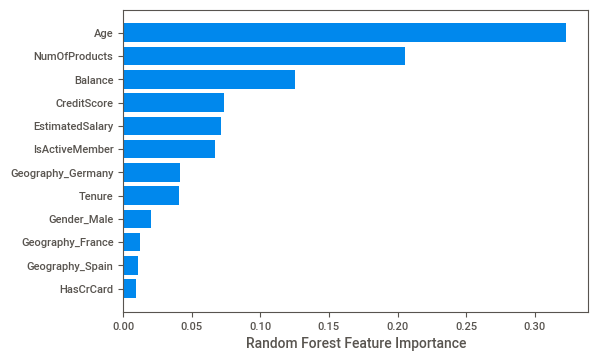

In [58]:
sorted_idx = model_rf_1.feature_importances_.argsort()
plt.barh(features_train.columns[sorted_idx], model_rf_1.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance");

Самые важные факторы при моделировании: возраст, количество продуктов банка, используемых клиентом и баланс на счёте.